# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import count

from my_maddpg import MADDPG

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

#initialize Agent
maddpg_agent = MADDPG(num_agents, state_size=state_size, action_size=action_size, random_seed=0)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


Episode 100	Average Score: -0.24
Episode 200	Average Score: -0.74
Episode 300	Average Score: -1.23
Episode 400	Average Score: -1.73
Episode 500	Average Score: -1.60
Episode 567	Average Score: 0.531
Environment solved in 467 episodes!	Average Score: 0.53


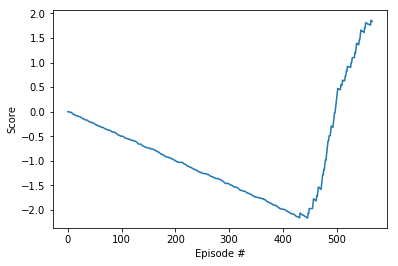

In [5]:
def maddpg(n_episodes=10000, max_t=1000):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    scores_epi = []
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        maddpg_agent.reset()
        time_step = 0; 
        for t in range(max_t):
            #actions = [agents[i].act(states[i]) for i in range(num_agents)]
            actions = maddpg_agent.m_act(states, noise)
            noise *= noise_reduction
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done 
            maddpg_agent.m_step(time_step, states, actions, rewards, next_states, dones) 
            states = next_states
            scores += rewards            
            if np.any(dones):
                break 

        score = np.max(scores)
        scores_deque.append(score)
        scores_epi.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")  
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 0.5:
            torch.save(maddpg_agent.get_Agent(0).actor_local.state_dict(), 'ddpg_network_actor_weight1.pth')
            torch.save(maddpg_agent.get_Agent(1).actor_local.state_dict(), 'ddpg_network_actor_weight2.pth')
            torch.save(maddpg_agent.get_Agent(0).critic_local.state_dict(), 'ddpg_network_critic_weight1.pth')
            torch.save(maddpg_agent.get_Agent(1).critic_local.state_dict(), 'ddpg_network_critic_weight2.pth')   
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))            
            break            
            
    return scores_epi


# should be two agents for the Tennis environment
assert num_agents == 2
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    
scores = maddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()